# 2.2: Two-Body Potential Energy Surface

Next, we will parameterize the "physical baseline" ($V_{phys}$) of the PEF.

In this section, we construct, from scratch, a 1-body MB-nrg-style PEF for CH3-NH2.

## 2.1.0 Definitions and Imports

In [69]:
%load_ext autoreload
%autoreload 2
%matplotlib agg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
%run Tutorial_2_Imports.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
%run Tutorial_2_Paths.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## II.1.? Normal Modes Configuration Generation

In [4]:
definition_CH3NH2 = read_definition(paths.definitions.systems.CH3NH2)
minimized_structure_CH3NH2, minimized_energy_CH3NH2 = read_system_and_energy(definition_CH3NH2, paths.structures.minimized_CH3NH2)

definition_H2O = read_definition(paths.definitions.systems.H2O)
minimized_structure_H2O, minimized_energy_H2O = read_system_and_energy(definition_H2O, paths.structures.minimized_H2O)

definition_CH3NH2_H2O = read_definition(paths.definitions.systems.CH3NH2_H2O)

In [5]:
clusters_CH3NH2_H2O = read_systems(definition_CH3NH2_H2O, paths.clusters.CH3NH2_H2O)
vibrational_modes_clusters_CH3NH2_H2O = read_multiple_vibrational_modes(paths.clusters.CH3NH2_H2O_modes)

In [6]:
configurations_vibrational_modes_CH3NH2_H2O = []

for cluster, modes in zip(clusters_CH3NH2_H2O, vibrational_modes_clusters_CH3NH2_H2O):
    configuration_generator = NormalModesConfigurationGenerator(
            cluster,
            modes,
            distribution="linear",
            temperature=(10, 150)
    )

    configs = list(configuration_generator.generate_configurations(num_configs=150, seed=54321))
    configurations_vibrational_modes_CH3NH2_H2O.extend(configs)
    
write_systems(paths.PIP_CH3NH2_H2O.configs.vibrational_modes, configurations_vibrational_modes_CH3NH2_H2O)

Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 150 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 150 configs.
Single negative frequency detected in input. This most likely means the given geometry is a transition state.
Will generate configurations over a linear temperature distribution from 10 K to 150 K.
Temp Distribution: temp (au) = 0.0004433562 * x + 3.1668299999999996e-05 for x in range [0,1].
Beginning normal modes configuration generation.
Will generate 150 configs over the temperature distribution.
Generating Temperature Distribution Configs...
Normal Distribution Configuration generation complete! Generated 150 configs.
Will generate configurations over a linear temperature

In [ ]:
render_overlayed_systems(
    configurations_vibrational_modes_CH3NH2_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[1].point),
    alpha=0.05,
    num_to_show=25
)

Let's generate the second set of configurations for our training set, those from metadynamics configurations.

## II.1.? Parallel-Bias Metadynamics Configuration Generation

In [7]:
bond_params, angle_params, nonbonded_params = get_pbmetad_parameters(
        clusters_CH3NH2_H2O[0]
)

In [8]:
bond_params

{('A', 'B'): (90, 1.0899397414464895),
 ('A', 'C'): (150, 1.486910273085358),
 ('C', 'D'): (90, 1.0326712127075615),
 ('E', 'F'): (90, 0.9893391033150292)}

In [9]:
angle_params

{('B', 'A', 'C'): (10, 110.4943292619306),
 ('A', 'C', 'D'): (10, 107.70357543974339),
 ('B', 'A', 'B'): (10, 108.41586747490726),
 ('F', 'E', 'F'): (10, 100.28909256644897),
 ('D', 'C', 'D'): (10, 104.65198159586903)}

In [10]:
nonbonded_params

{'A': (0.03, 2.2),
 'B': (0.01, 1.2),
 'C': (0.03, 2.2),
 'D': (0.01, 1.2),
 'E': (0.03, 2.2),
 'F': (0.01, 1.2)}

In [11]:
charges = read_parameters(paths.Vphys.charges)
charges = {symmetry: charges[symmetry]*1/3 for symmetry in charges}
charges["E"] = -0.6*1/3
charges["F"] = +0.3*1/3

In [12]:
perform_pbmetad_simulation(
        lammps_executable_path,
        [minimized_structure_CH3NH2, minimized_structure_H2O],
        num_configs=500000,
        sample_interval=10,
        temperature=700,
        seed=12345,
        configurations_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_pool,
        bond_params=bond_params,
        angle_params=angle_params,
        nonbonded_params=nonbonded_params,
        charges=charges,
        pbmetad_workdir=paths.scratch.pbmetad_CH3NH2_H2O,
        restart_path=paths.restart.pbmetad_CH3NH2_H2O,
        min_intermolecular_distance=1.5,
        max_intermolecular_distance=9.0
)

PBMetaD already completed. Will not rerun!


In [13]:
inner_cutoff_2b = 6.0
outer_cutoff_2b = 7.0

In [14]:
num_filtered_configs = filter_configs_by_cutoff(
        definition_CH3NH2_H2O,
        paths.PIP_CH3NH2_H2O.configs.pbmetad_pool,
        threshold=outer_cutoff_2b,
        filtered_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_pool_filtered
)

Found 365549 within cutoff distance of 7.0


In [15]:
split_pool(
        definition_CH3NH2_H2O,
        paths.PIP_CH3NH2_H2O.configs.pbmetad_pool_filtered,
        pool_size=num_filtered_configs,
        num_configs_to_split=200,
        unsplit_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_train_pool,
        split_path=paths.PIP_CH3NH2_H2O.configs.pbmetad_test,
        strategy="INTERVAL",
)

In [16]:
pbmetad_configs_CH3NH2_H2O = perform_fps(
        definition_CH3NH2_H2O,
        clusters_CH3NH2_H2O[0],
        vibrational_modes_clusters_CH3NH2_H2O[0],
        paths.PIP_CH3NH2_H2O.configs.pbmetad_train_pool,
        num_pool_configs=num_filtered_configs-200,
        num_phase1_input_configs=100000,
        approx_configs_to_select=2000,
        fps_workdir=paths.scratch.fps_CH3NH2_H2O,
        restart_path=paths.restart.fps_CH3NH2_H2O,
        num_threads=16
)

Phase1 already complete. Will not rerun.
Phase2 already complete. Will not rerun.
Selected 2566 total configs by FPS.


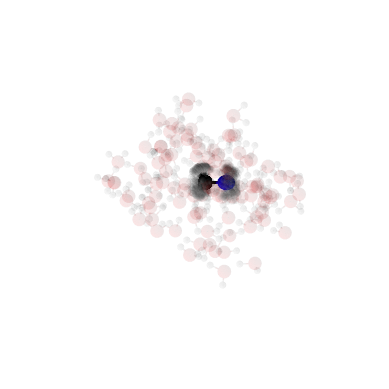

In [63]:
render_overlayed_systems(
    pbmetad_configs_CH3NH2_H2O,
    centerer=lambda system: system.atoms[0].point,
    aligner=lambda system: (system.atoms[4].point, system.atoms[3].point),
    alpha=0.05,
    num_to_show=100
)

In [64]:
write_systems(paths.PIP_CH3NH2_H2O.configs.pbmetad_train, pbmetad_configs_CH3NH2_H2O)

## II.1.? Energy Calculation

Next, we need to perform the electronic structure calculations with our chosen reference level of theory. We will use CCSD(T). Because this can be quite expensive and this tutorial is menat to be something that can be finished in a few hours, we have precomputed the energies for you. So we will just copy them over:

In [21]:
calculator = Psi4Calculator(
        "MP2",
        "def2-TZVP",
        log_directory=paths.logs,
        scratch_directory=paths.scratch.psi4
)

In [ ]:
energies_vibrational_modes_CH3NH2_H2O = calculate_nmer_energies(
        configurations_vibrational_modes_CH3NH2_H2O,
        calculator,
        paths.restart.energies_vibrational_mode_configs_CH3NH2_H2O,
        num_threads=8,
        mem_mb=8000,
        error_on_any_failure=False,
        retrieve_only=True
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O.configs.vibrational_modes_energies, (configurations_vibrational_modes_CH3NH2_H2O, energies_vibrational_modes_CH3NH2_H2O))

In [ ]:
energies_pbmetad_CH3NH2_H2O = calculate_nmer_energies(
        pbmetad_configs_CH3NH2_H2O,
        calculator,
        paths.restart.energies_pbmetad_configs_CH3NH2_H2O,
        num_threads=8,
        mem_mb=8000,
        error_on_any_failure=False,
        retrieve_only=True
)
write_systems_and_nmer_energies(paths.PIP_CH3NH2_H2O.configs.pbmetad_train_energies, (pbmetad_configs_CH3NH2_H2O, energies_pbmetad_CH3NH2_H2O))

In [31]:
configurations_vibrational_modes_CH3NH2_H2O, energies_vibrational_modes_CH3NH2_H2O = discard_failed_configurations(
        configurations_vibrational_modes_CH3NH2_H2O,
        energies_vibrational_modes_CH3NH2_H2O
)

pbmetad_configs_CH3NH2_H2O, energies_pbmetad_CH3NH2_H2O = discard_failed_configurations(
        pbmetad_configs_CH3NH2_H2O,
        energies_pbmetad_CH3NH2_H2O
)

Checking for missing energies |====================================================================================================| - 412/412
Found 0 systems with one or more missing n-mer energies. Remaining configurations: 412
Checking for missing energies |====================================================================================================| - 2566/2566
Found 0 systems with one or more missing n-mer energies. Remaining configurations: 2566


In [32]:
energies_2b_vibrational_modes_CH3NH2_H2O = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2_H2O,
    energies_vibrational_modes_CH3NH2_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O]
)

energies_2b_pbmetad_CH3NH2_H2O = calculate_many_body_energies(
    pbmetad_configs_CH3NH2_H2O,
    energies_pbmetad_CH3NH2_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O]
)

In [39]:
energies_binding_vibrational_modes_CH3NH2_H2O = calculate_binding_energies(
    configurations_vibrational_modes_CH3NH2_H2O,
    energies_vibrational_modes_CH3NH2_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O]
)

energies_binding_pbmetad_CH3NH2_H2O = calculate_binding_energies(
    pbmetad_configs_CH3NH2_H2O,
    energies_pbmetad_CH3NH2_H2O,
    minimized_monomer_energies=[minimized_energy_CH3NH2, minimized_energy_H2O]
)

In [60]:
write_training_set_file(
        paths.PIP_CH3NH2_H2O.training_set,
        (
                [*configurations_vibrational_modes_CH3NH2_H2O, *pbmetad_configs_CH3NH2_H2O],
                [*energies_binding_vibrational_modes_CH3NH2_H2O, *energies_binding_pbmetad_CH3NH2_H2O],
                [*energies_2b_vibrational_modes_CH3NH2_H2O, *energies_2b_pbmetad_CH3NH2_H2O],
        )
)

In [41]:
min(energies_binding_vibrational_modes_CH3NH2_H2O), max(energies_binding_vibrational_modes_CH3NH2_H2O)

(-3.5876719700099784, 723.0923280299976)

In [42]:
min(energies_binding_pbmetad_CH3NH2_H2O), max(energies_binding_pbmetad_CH3NH2_H2O)

(16.632328029991186, 417.71232802999293)

## II.1.? Polynomial Generation

In [49]:
pip_2b_max_order = 3

In [64]:
generate_polynomial(
        definition_CH3NH2_H2O,
        max_degree=pip_2b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2_H2O.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2_H2O.PIP.polynomial,
        filters=[
                "add_filter['sum-degree', 'x-inter-*+*-*', '0']",
                "add_filter['sum-degree', 'x-intra-*+*-*', '2+']",
        ]
)

(A1B3C1D2)_(E1F2)
Generating polynomial input file for symmetry (A1B3C1D2)_(E1F2) into file Tutorial_2_workdir/PIP_CH3NH2_H2O/PIP/info.in.
Successfully generated polynomial input file! 45 total variables.
File Tutorial_2_workdir/PIP_CH3NH2_H2O/PIP/polynomial/poly.log already exists, moving existing Tutorial_2_workdir/PIP_CH3NH2_H2O/PIP/polynomial/poly.log to Tutorial_2_workdir/PIP_CH3NH2_H2O/PIP/polynomial/poly.log.backup-3 to make way for new file.
Generating terms up to degree 3...
Generating polynomial: |====================================================================================================| - 135/135
18 possible degree 1 terms, now filtering them...
There were 8 accepted degree 1 terms.
225 possible degree 2 terms, now filtering them...
There were 152 accepted degree 2 terms.
2266 possible degree 3 terms, now filtering them...
There were 1023 accepted degree 3 terms.
There were 1183 accepted terms over all
Writing Gradients C++: |=======================================

## II.1.? Polynomial Parametrization

In [65]:
polarizabilities = read_parameters(paths.Vphys.polarizabilities)
polarizability_factors = read_parameters(paths.Vphys.polarizability_factors)
charges = read_parameters(paths.Vphys.charges)
C6 = read_parameters(paths.Vphys.C6)
d6 = read_parameters(paths.Vphys.d6)

In [66]:
print("polarizabilities:", polarizabilities)
print("polarizability_factors:", polarizability_factors)
print("charges:", charges)
print("C6:", C6)
print("d6:", d6)

polarizabilities: {'A': 1.197286837688588, 'B': 0.3338549392278207, 'C': 0.936690107093768, 'D': 0.35079895087010643, 'E': 1.31, 'F': 0.294}
polarizability_factors: {'A': 1.197286837688588, 'B': 0.3338549392278207, 'C': 0.936690107093768, 'D': 0.35079895087010643, 'E': 1.31, 'F': 0.294}
charges: {'A': 0.19712181192295436, 'B': -0.007316083425489981, 'C': -0.6523113428259786, 'D': 0.2385688905897471}
C6: {('A', 'E'): 213.33108737196045, ('A', 'F'): 101.90479632213754, ('A', 'A'): 287.58772280972653, ('A', 'B'): 100.71518361858206, ('A', 'C'): 245.27149949753883, ('A', 'D'): 101.84278948237693, ('B', 'E'): 81.0911671091582, ('B', 'F'): 37.128317718883046, ('B', 'B'): 36.90402137258849, ('B', 'C'): 89.56084211053388, ('B', 'D'): 37.054828131018624, ('C', 'E'): 196.20342030030648, ('C', 'F'): 90.13727606534552, ('C', 'C'): 217.4097594984364, ('C', 'D'): 89.97192449265054, ('D', 'E'): 80.93270518532552, ('D', 'F'): 37.3074485893026, ('D', 'D'): 37.24888657397313, ('E', 'E'): 237.32122141479

In [67]:
generate_pip_parametizer(
        definition_CH3NH2_H2O,
        max_degree=pip_2b_max_order,
        polynomial_info_path=paths.PIP_CH3NH2_H2O.PIP.info,
        polynomial_dir=paths.PIP_CH3NH2_H2O.PIP.polynomial,
        parametizer_dir=paths.PIP_CH3NH2_H2O.PIP.parameterizer,
        workdir=paths.scratch.PIP_CH3NH2_H2O,
        symmetry_to_charge=charges,
        symmetry_to_polarizability=polarizabilities,
        symmetry_to_polarizability_factor=polarizability_factors,
        symmetries_to_C6=C6,
        symmetries_to_d6=d6,
        monomer_names=["ch3nh2", "h2o"],
        is_mbpol=[False, True]
)

File Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini already exists, moving existing Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini to Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini.backup-2 to make way for new file.
Completed generating config file Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini.
File Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini already exists, moving existing Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini to Tutorial_2_workdir/scratch/PIP_CH3NH2_H2O/config.ini.backup-3 to make way for new file.
Executing python generator script
Generating fitcode for molecule with symmetry A1B3C1D2_E1F2...
Using mbpol for 1 fragments.
0 fragments have lone pairs.
Using exp variables for intramolecular interactions.
Using exp variables for intermolecular interactions.
Using coul variables for lone pair interactions.
1183 terms in the polynomial.
Atoms in the molecule: A1 B1 B2 B3 C1 D1 D2 E1 F1 F2.
45 variables in the polynomial.
18 non-linear param

In [68]:
parametrize_pip(
        definition_CH3NH2_H2O,
        parametizer_dir=paths.PIP_CH3NH2_H2O.PIP.parameterizer,
        parametrization_dir=paths.PIP_CH3NH2_H2O.PIP.parametrization,
        training_set_path=paths.PIP_CH3NH2_H2O.training_set,
        workdir=paths.scratch.fitting_CH3NH2_H2O,
        monomer_names=["ch3nh2", "h2o"],
        is_mbpol=[False, True],
        num_fits_to_run=1,
        num_threads=16,
        DE=10,
        alpha=0.0005
)

Succesfully created fit folder fit1.
fit1 is running.

fit1 is completed.
Looks like the fit in fit1 didn't converge...
Maybe you want to rerun fit1 again.
Best fit is fit fit1.
Fit with lowest RMSD did not converge, maybe run it again with more iterations?
Still using that fit as the best one.
No previous best fit, so just storing the current best fit.
Best fit found has a weighted RMSD of 12.9724 kcal/mol, a low energy RMSD of 1.91475 kcal/mol, and a maximum error in the low energy training set of 5.50003 kcal/mol


## 2.x.y Implementation in MBX

In [33]:
add_PIP_to_MBX(
        paths.MBX,
        definition_CH3NH2_H2O,
        ["ch3nh2", "h2o"],
        paths.PIP_CH3NH2_H2O.PIP.parameterizer,
        paths.PIP_CH3NH2_H2O.PIP.parametrization,
        max_degree=pip_2b_max_order,
        workdir=paths.scratch.fitting_CH3NH2_H2O,
)

Getting polynomial fitted parameters...
Getting energy calls...


In [ ]:
compile_mbx(
        paths.MBX,
        configure_arguments=[
                "CXX=icpc",
                "CC=icc",
                "--disable-optimization"
        ],
        configure=True,
        clean=False,
        num_threads=4
)

In [80]:
predicted_energies_vibrational_modes_CH3NH2_H2O = calculate_MBX_nmer_energies(
        paths.MBX,
        definition_CH3NH2_H2O,
        configurations_vibrational_modes_CH3NH2_H2O,
        monomer_names=["ch3nh2", "h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O
)

MBX energy calculations: |====================================================================================================| - 1000/1000


In [83]:
predicted_energies_pbmetad_CH3NH2_H2O = calculate_MBX_nmer_energies(
        paths.MBX,
        definition_CH3NH2_H2O,
        pbmetad_configs_CH3NH2_H2O,
        monomer_names=["ch3nh2", "h2o"],
        scratch_dir=paths.scratch.fitting_CH3NH2_H2O
)

MBX energy calculations: |====================================================================================================| - 1561/1561


In [94]:
predicted_energies_2b_vibrational_modes_CH3NH2_H2O = calculate_many_body_energies(
    configurations_vibrational_modes_CH3NH2_H2O,
    predicted_energies_vibrational_modes_CH3NH2_H2O,
    minimized_monomer_energies=[0.0, 0.0]
)

predicted_energies_2b_pbmetad_CH3NH2_H2O = calculate_many_body_energies(
    pbmetad_configs_CH3NH2_H2O,
    predicted_energies_pbmetad_CH3NH2_H2O,
    minimized_monomer_energies=[0.0, 0.0]
)

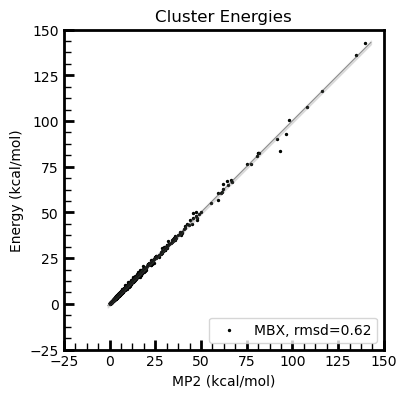

In [142]:
plot_correlation(
    configurations_vibrational_modes_CH3NH2_H2O,
    energies_2b_vibrational_modes_CH3NH2_H2O,
    "MP2",
    {"MBX": predicted_energies_2b_vibrational_modes_CH3NH2_H2O},
    error_width=1.0
)

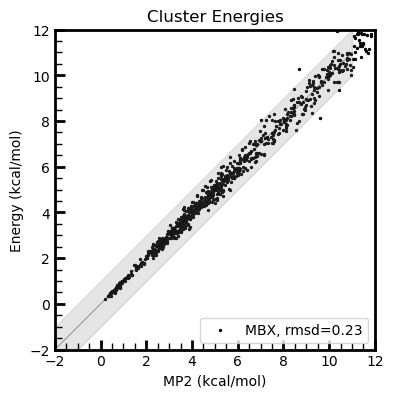

In [143]:
plot_correlation(
    configurations_vibrational_modes_CH3NH2_H2O,
    energies_2b_vibrational_modes_CH3NH2_H2O,
    "MP2",
    {"MBX": predicted_energies_2b_vibrational_modes_CH3NH2_H2O},
    minE=-1,
    maxE=10,
    error_width=1.0
)

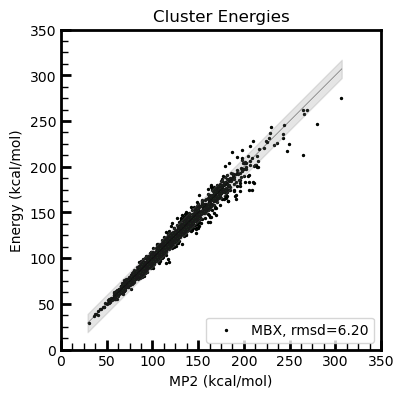

In [144]:
plot_correlation(
    pbmetad_configs_CH3NH2_H2O,
    energies_2b_pbmetad_CH3NH2_H2O,
    "MP2",
    {"MBX": predicted_energies_2b_pbmetad_CH3NH2_H2O},
    error_width=10.0
)